## Set up

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
import seaborn as sns

from fit import fit_categorical_survival, categorical_signal
from models import MergeRareCategories
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, categorical_input_columns, evaluate_training_size_dependence, pipelines, reconstruct_categorical_variable_names_Richard
from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets, survival_histograms
from views import categorical_signal_summary, plot_confusion_matrix, view_as_exponential, view_decision_tree_julian, view_linear_model_richard

In [2]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [3]:
load_process_and_store_spreadsheets(spread_sheet_filename='2019-08-27_PLASMA_SOMATIC_Results_groningen.xlsx', transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Overall survival and progression free survival
### Population results
To first get an idea of the overall factors, we have a brief look at the data as a whole.

In [4]:
# Combined set for analysis only (not to be used for models).
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

First calculate distribution of the overall survival (OS) and progression free survival (PFS) and the cumulative distribution.

In [5]:
# Calculate the distribution and cumulative distribution for:
# 1) overall survival.
(t_OS, p_OS), (t_OS_cum, p_OS_cum) = survival_histograms(y['OS_days'], hist_bins=10, cum_hist_bins=15)
# 2) progression free survival.
(t_PFS, p_PFS), (t_PFS_cum, p_PFS_cum) = survival_histograms(y['PFS_days'], hist_bins=10, cum_hist_bins=15)

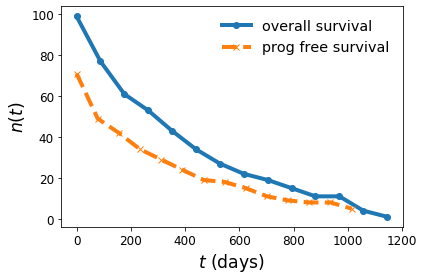

In [6]:
plt.figure()
plt.plot(t_OS_cum, p_OS_cum, '-o', label='overall survival')
plt.plot(t_PFS_cum, p_PFS_cum, '--x', label='prog free survival')
plt.xlabel('$t$ (days)')
plt.ylabel('$n(t)$')
plt.legend(frameon=False)

which clearly shows an exponentially decaying function (as a side note, if the original distribution is exponential, than so is the cumulative function). 

If patients indeed decay exponentially
$$N(t) = N_0 \exp\left(-\frac{t}{\tau}\ln 2\right) ,$$
then the half life $\tau$ can be determined from the slope
$$
\ln[N(t)] = -\frac{\ln 2}{\tau} t + \ln N_0.
$$
Let us fit this to the distribution:


(-22.88, 1166.88)

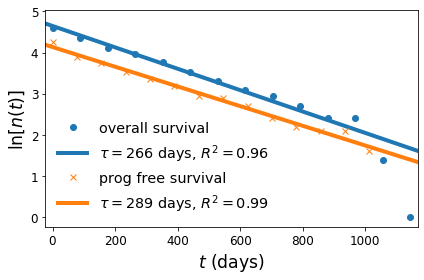

In [7]:
# The last datum is an outlier.
outliers = [len(p_OS_cum) - 1]
view_as_exponential(t_OS_cum, p_OS_cum, outlier_indices=outliers, markers=['o', '-'], label='overall survival')
view_as_exponential(t_PFS_cum, p_PFS_cum, markers=['x', '-'], label='prog free survival')
plt.gca()
dt = t_OS_cum[-1] - t_OS_cum[0]
plt.xlim([t_OS_cum[0] - 0.02*dt, t_OS_cum[-1] + 0.02*dt])

### Phenotype differences
Two exponentials form approximately an exponential
$$
\frac{n_1}{N} e^{-\alpha_1 t} + \frac{n_2}{N} e^{-\alpha_2 t} \approx \exp\left(-\frac{n_1}{N}\alpha_1 t - \frac{n_2}{N}\alpha_2t \right) \equiv \exp(-\alpha t) ,
$$
with $N=n_1 + n_2$, when $n_2(\alpha_1 - \alpha_2)/N t \ll 1$ for relevant $t$. That is, our new $\alpha$ is a weighted average of the individual ones.

In [8]:
# First merge all categories that occur less than 30 times.
X = MergeRareCategories(thresshold=30, categorical_columns=categorical_input_columns).fit_transform(X)

In [9]:
from fit import fit_categorical_survival

X['gender']
df = fit_categorical_survival(X['gender'], y['OS_days'])
df

,tau,sigma_t,n,r
all,220.426,315.37,128,-0.93622
male,244.136,331.585,72,-0.943956
female,241.105,287.685,56,-0.992067


In [10]:
effect_summary = categorical_signal_summary(X, y['OS_days'], categorical_input_columns)

In [11]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                              3.03   
stage               4-3                                                     32.54   
therapyline         2-1+3+4                                                 46.45   
smokingstatus       smoker-unknown+non smoker                              168.85   
                    smoker-previous                                        112.03   
                    unknown+non smoker-previous                             56.82   
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...      23.80   
histology_grouped   adeno-squamous                                          13.85   
                    adeno-other                                            157.41   
                    squamous-other                                         171.25   
lymfmeta            metastasis present-no metastasis present               132.45   
brainmeta           no metastasis present-metastasis present                65.31   
adrenalmeta         no metastasis present-metastasis present                35.50   
livermeta           no metastasis present-metastasis present                17.82   
lungmeta            metastasis present-no metastasis present                40.95   
skeletonmeta        no metastasis present-metastasis present                41.51   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.01  
stage               4-3                                                            0.10  
therapyline         2-1+3+4                                                        0.15  
smokingstatus       smoker-unknown+non smoker                                      0.54  
                    smoker-previous                                                0.36  
                    unknown+non smoker-previous                                    0.18  
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...             0.08  
histology_grouped   adeno-squamous                                                 0.04  
                    adeno-other                                                    0.50  
                    squamous-other                                                 0.54  
lymfmeta            metastasis present-no metastasis present                       0.42  
brainmeta           no metastasis present-metastasis present                       0.21  
adrenalmeta         no metastasis present-metastasis present                       0.11  
livermeta           no metastasis present-metastasis present                       0.06  
lungmeta            metastasis present-no metastasis present                       0.13  
skeletonmeta        no metastasis present-metastasis present                       0.13

In [12]:
effect_summary.round(2)

delta tau  \
category            item                                                            
gender              male-female                                              3.03   
stage               4-3                                                     32.54   
therapyline         2-1+3+4                                                 46.45   
smokingstatus       smoker-unknown+non smoker                              168.85   
                    smoker-previous                                        112.03   
                    unknown+non smoker-previous                             56.82   
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...      23.80   
histology_grouped   adeno-squamous                                          13.85   
                    adeno-other                                            157.41   
                    squamous-other                                         171.25   
lymfmeta            metastasis present-no metastasis present               132.45   
brainmeta           no metastasis present-metastasis present                65.31   
adrenalmeta         no metastasis present-metastasis present                35.50   
livermeta           no metastasis present-metastasis present                17.82   
lungmeta            metastasis present-no metastasis present                40.95   
skeletonmeta        no metastasis present-metastasis present                41.51   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                    0.01  
stage               4-3                                                            0.10  
therapyline         2-1+3+4                                                        0.15  
smokingstatus       smoker-unknown+non smoker                                      0.54  
                    smoker-previous                                                0.36  
                    unknown+non smoker-previous                                    0.18  
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...             0.08  
histology_grouped   adeno-squamous                                                 0.04  
                    adeno-other                                                    0.50  
                    squamous-other                                                 0.54  
lymfmeta            metastasis present-no metastasis present                       0.42  
brainmeta           no metastasis present-metastasis present                       0.21  
adrenalmeta         no metastasis present-metastasis present                       0.11  
livermeta           no metastasis present-metastasis present                       0.06  
lungmeta            metastasis present-no metastasis present                       0.13  
skeletonmeta        no metastasis present-metastasis present                       0.13

In [13]:
effect_summary = categorical_signal_summary(X, y['PFS_days'], categorical_input_columns)
effect_summary

delta tau  \
category            item                                                             
gender              male-female                                           0.110442   
stage               4-3                                                  55.556812   
therapyline         2-1+3+4                                              76.705358   
smokingstatus       smoker-unknown+non smoker                            36.217508   
                    smoker-previous                                      49.095083   
                    unknown+non smoker-previous                          12.877575   
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...   25.749488   
histology_grouped   adeno-squamous                                       82.203859   
                    adeno-other                                         286.560880   
                    squamous-other                                      204.357021   
lymfmeta            metastasis present-no metastasis present             63.268711   
brainmeta           no metastasis present-metastasis present            165.644569   
adrenalmeta         no metastasis present-metastasis present              1.905582   
livermeta           no metastasis present-metastasis present            163.035884   
lungmeta            metastasis present-no metastasis present              1.486204   
skeletonmeta        no metastasis present-metastasis present             77.198863   

                                                                        signal to noise  
category            item                                                                 
gender              male-female                                                0.000384  
stage               4-3                                                        0.193076  
therapyline         2-1+3+4                                                    0.266574  
smokingstatus       smoker-unknown+non smoker                                  0.125867  
                    smoker-previous                                            0.170620  
                    unknown+non smoker-previous                                0.044753  
Systemischetherapie nivolumab-pembrolizumab+atezolizumab+ipi-novu+n...         0.089487  
histology_grouped   adeno-squamous                                             0.285683  
                    adeno-other                                                0.995883  
                    squamous-other                                             0.710201  
lymfmeta            metastasis present-no metastasis present                   0.219877  
brainmeta           no metastasis present-metastasis present                   0.575664  
adrenalmeta         no metastasis present-metastasis present                   0.006622  
livermeta           no metastasis present-metastasis present                   0.566598  
lungmeta            metastasis present-no metastasis present                   0.005165  
skeletonmeta        no metastasis present-metastasis present                   0.268289

### Theoretical lower bound on model performance
Assuming the worst case scenario, we can now derive a lower bound on the mean squared error, given that the data is distributed according to the exponentially decaying function.

Normalising $N(t) = N_0 e^{-t \ln 2 / \tau}$ to $p(t)$ gives 
$$
p(t) = \alpha e^{-\alpha t} ,
$$
with $\alpha = \ln 2/\tau$. The standard deviation is nothing but the root mean squared error of the average:
$$
\sigma_t^2 = \langle t^2 \rangle - \langle t \rangle^2 .
$$
Calculating the avarage $\langle t \rangle = 1/\alpha$ and the two point function $\langle t^2 \rangle= 2/\alpha^2$ allows one to express the standard deviation as.
$$
\sigma_t^2 = \alpha^{-2} = \left( \frac{\tau}{\ln 2} \right)^2 .
$$
A model should at least be able to out perform the following mean squared error:
$$
\Delta e^2 = \frac{1}{N}\left(n_1 \frac{{\tau_1}^2}{\ln^2 2} + n_2 \frac{{\tau_2}^2}{\ln^2 2} \right) \, .
$$

Using the value above $\tau =258$ days gives a variance of

### Tuning the pipeline
We use a variety of different pipelines and different algorithms to try to squeeze as much signal from the data as possible. Let us focus on the overall survival first.

In [14]:
# Construct a variety of pipelines.
pipelines = build_regression_pipelines()

# And benchmark them using the root mean squared error.
rmse = lambda x, y: mean_squared_error(x, y) ** 0.5

Briefly, the types of models in this list:
- Decision tree: Consecutively split the data in two branches based on one of the variables.
- Random forest: collection of decision trees in parallel, each tree gets a subset of the training data.
- Gradient boosting: collection of decision trees in series, each refining the result of the previous tree.
- K-neighbours: Use average of $k$ neighbouring points.
- Elastic net: Linear regression with penalties on the slopes.
- SVR: Support vector machine that implicitly takes into account polynomials of the input variables.
- DummyRegressor: Baseline model that predicts according a specific rule (in this case, take the median value).

Pipelines:
- Richard: Use only phenotype data, and some categorical preprocessing.
- Julian: Convert mutation data to columns using transformation described above (harmonic mean).
- Freeman: Use all data together.
- Lev: Democratic vote of Richard & Julian.

#### overall survival

In [15]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,376.455969,405.370492,430.971618,375.615570
RandomForestRegressor,365.910320,375.293464,362.175143,360.853676
GradientBoostingRegressor,367.824080,375.587787,374.489876,366.967924
KNeighborsRegressor,392.878979,378.674119,377.064260,377.130761
ElasticNet,367.005444,365.324934,364.461015,364.386685
LinearRegression,363.924589,410.006320,8802.601713,366.285211
SVR,381.542456,381.579945,381.526361,381.556278
DummyRegressor,381.337827,381.337827,381.337827,381.337827


### Training size dependence

In [16]:
p_Lev = pipelines['LinearRegression']['Lev']
m, err = evaluate_training_size_dependence(p_Lev, X_train, y_train["OS_days"], X_test, y_test["OS_days"], metric=rmse)

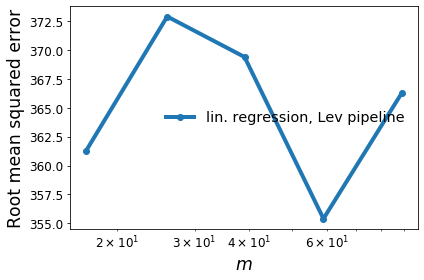

In [17]:
plt.ylabel('Root mean squared error')
plt.xlabel('$m$')
plt.semilogx(m ,err, 'o-', label='lin. regression, Lev pipeline')
plt.legend(frameon=False)

The data indicates that the linear regression model with the `Lev` pipeline (which combines the `Richard` and `Julian` pipelines) gives the best results.

#### progression free survival

In [18]:
benchmark_result = benchmark_pipelines(
    pipelines, X_train, y_train["PFS_days"], X_test, y_test["PFS_days"], metric=rmse
)
benchmark_result

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,337.795771,355.237211,383.686393,339.875272
RandomForestRegressor,328.572564,358.858515,341.342539,337.809257
GradientBoostingRegressor,338.961545,343.226023,359.453747,338.068121
KNeighborsRegressor,346.691756,339.845939,319.195665,334.830398
ElasticNet,340.388177,338.995056,325.142911,337.789480
LinearRegression,336.494368,457.242987,13243.859371,371.297919
SVR,380.255439,379.956529,380.256462,380.105587
DummyRegressor,380.342524,380.342524,380.342524,380.342524


- $\Delta \tau$ 
- Calculation of $\Delta \tau$ for various phenotypes.
- Tuning of pipeline.
- Somatic vs all
- Hybrid model best performance.
### Decypher effects of input features

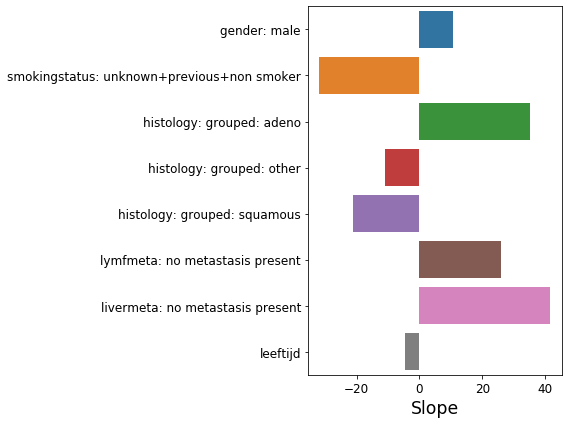

In [19]:
p_richard = pipelines['ElasticNet']['Richard']
view_linear_model_richard(pipeline=p_richard)

[12170.04128744 -2604.49325918 -2135.97414272   723.07230454
 -6392.93079657 -1567.52142803  1974.05476378 33635.87643762
  -690.07853361  1421.38237235 -4025.61108724 -3395.64294173
 -2756.86284031 -2658.51037468]


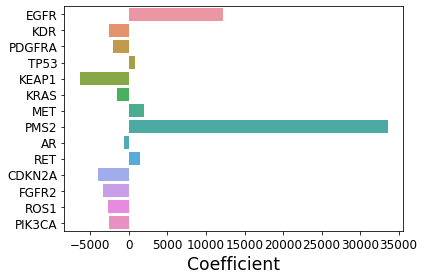

In [20]:
p_julian = pipelines['LinearRegression']['Julian']
classifier = p_julian.steps[-1][1]
column_names = p_julian.steps[-2][1].columns_to_keep_
print(classifier.coef_)
with sns.plotting_context(font_scale=1.5):
#     plt.figure(figsize=(14, 6))
    plt.xlabel(r"Coefficient")
    sns.barplot(x=classifier.coef_, y=column_names, label="large")
    plt.tight_layout()


The sheer size of the coefficients are related to the size of the input variables (which are calculated using the harmonic mean). But the positive sign of `TP53` indicates that the presence of this variable is indicative for prolonger survival.

## Classification
**Goal**: Identify patients that don't respond.

These patients we don't have to treat.

In [21]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
pos_label = 'non responder (sd+pd)'

We want to:
- Maximize our predictive capacity, we do this by maximizing the area under receiver operating curve.
- And at the same time, we don't want to deny patients treatment that could potentially benefit.

The latter statement translates to a minimisation of false positives (predicted is non-responder \[=positive\], but is actually a responder \[=false\]).

We use the area under the receiver operating curve $r_{\mathrm{TP}}(r_{\mathrm{FP}})$:
$$
    A = \int_0^1 r_{\mathrm{TP}}(r_{\mathrm{FP}}) \, \mathrm{d}r_{\mathrm{FP}} \, .
$$
to quantify the models predictive capacity.

In [22]:
# We evaluate the predictive capacity using AUC of ROC.
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [23]:
ps_class = build_classifier_pipelines()

In [24]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=auc,
)
print(b.round(2).to_latex())

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


\begin{tabular}{lrrrr}
\toprule
{} &  Richard\_test &  Julian\_test &  Freeman\_test &  Lev\_test \\
\midrule
DecisionTreeClassifier     &          0.41 &         0.60 &          0.53 &      0.56 \\
RandomForestClassifier     &          0.40 &         0.57 &          0.55 &      0.46 \\
GaussianNB                 &          0.43 &         0.58 &          0.52 &      0.53 \\
GradientBoostingClassifier &          0.50 &         0.48 &          0.48 &      0.50 \\
KNeighborsClassifier       &          0.48 &         0.42 &          0.51 &      0.50 \\
LogisticRegression         &          0.41 &         0.50 &          0.54 &      0.50 \\
SVC                        &          0.50 &         0.50 &          0.50 &      0.50 \\
DummyClassifier            &          0.50 &         0.50 &          0.50 &      0.50 \\
\bottomrule
\end{tabular}



It seems that our `Julian` pipeline using a DecisionTreeClassifier is the overall winner. Let us take a more in depth look at the confusion matrix.

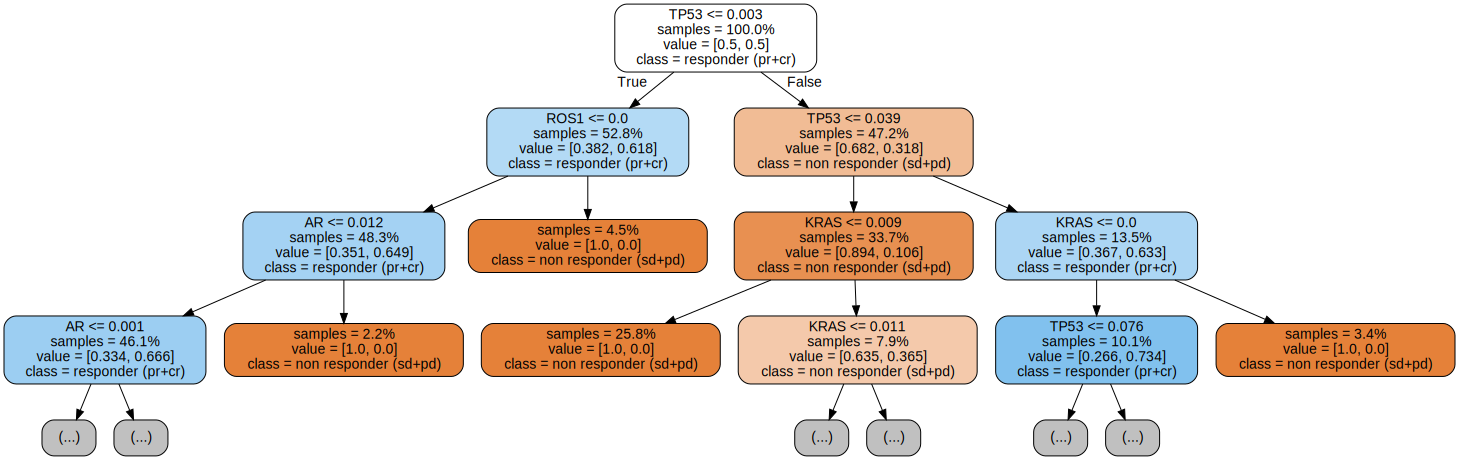

In [25]:
p_win = ps_class['DecisionTreeClassifier']['Julian']
view_decision_tree_julian(p_win, save_to='classifier_tree.png')

Confusion matrix, without normalization
[[16 12]
 [ 4  7]]


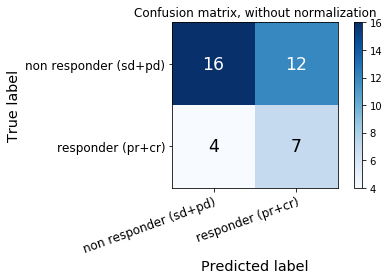

In [26]:
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

In [27]:
pos_label_index = np.argwhere(p_win.classes_ == pos_label)[0][0]
p = p_win.predict_proba(X_test)[:, pos_label_index]

fpr, tpr, thresholds = roc_curve(y_test_resp.values, p, pos_label=pos_label)

Text(0, 0.5, '$r_{\\mathrm{TP}}$')

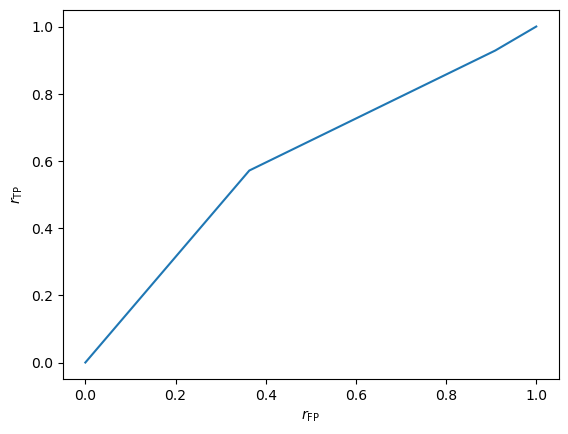

In [28]:
plt.plot(fpr, tpr)
plt.xlabel(r'$r_{\mathrm{FP}}$')
plt.ylabel(r'$r_{\mathrm{TP}}$')

In [29]:
print(type(y_test_resp.values))
print(type(p_win.predict(X_test)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Training size dependence.

In [30]:
p_Julian = ps_class['DecisionTreeClassifier']['Julian']
m, err = evaluate_training_size_dependence(p_Julian, X_train, y_train_resp, X_test, y_test_resp, metric=auc)

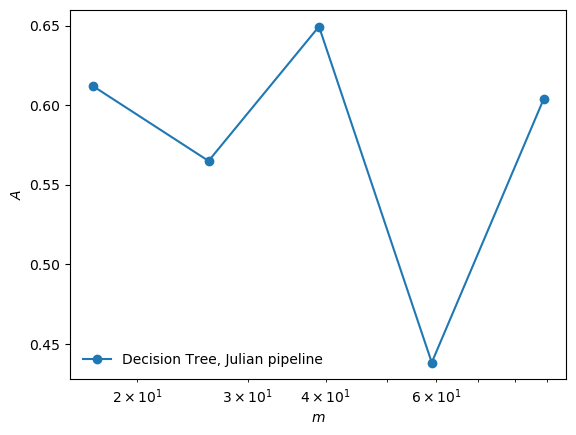

In [31]:
plt.semilogx(m ,err, 'o-', label='Decision Tree, Julian pipeline')
plt.ylabel('$A$')
plt.xlabel('$m$')
plt.legend(frameon=False)